# Preprocessing & Modeling

##### Imported libraries.

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import MultinomialNB
from pactools.grid_search import GridSearchCVProgressBar

import warnings
warnings.filterwarnings('ignore')

##### Read in previously saved csv file with cleaned data.

In [2]:
df = pd.read_csv('./datasets/lyft_uber_all.csv')

In [3]:
df.head()

,subreddit,text
0,0,Nightlife PlaylistI usually drive people going...
1,1,Uber should add this feature to their app to m...
2,1,Interest in starting but I drive a JeepI want ...
3,0,"Uber or Lyft while vacationingSo, I would like..."
4,0,"I got co-erced into getting someone a Lyft, wh..."


## Transformation Methods: 
-Count Vectorizor<br>
-TF-IDF

## Classification Models: 
-Logistic Regression <br>
-K-Nearest Neighbors <br>
-Naive Bayes <br>
-Random Forest

##### Train/Test Split to be used for all models

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['subreddit'],
                                                    test_size=0.30,
                                                    random_state=27)

##### Baseline to improve upon: 50.1%

In [5]:
# determine baseline
baseline = y_train.mean()
baseline

0.5010204081632653

## Model 1: Count Vectorizer + Logistic Regression

In [65]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logr', LogisticRegression())])

params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__min_df' : [2, 11, 22, 54],
    'cvec__max_features' : [None, 700, 500, 200, 20],
    'logr__penalty': ['l1', 'l2'],
    'logr__C': [0.1, 0.4, 0.7, 1.0]}


model_1 = GridSearchCVProgressBar(pipe, params, cv = 3)
model_1.fit(X_train, y_train)

[........................................] 100% | 124.18 sec | GridSearchCV 


GridSearchCVProgressBar(cv=3, error_score='raise',
            estimator=Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
            fit_params=None, iid=True, n_jobs=1,
            param_grid={'cvec__stop_words': [None, 'english'], 'cvec__min_df': [2, 11, 22, 54], 'cvec__max_features': [None, 700, 500, 200, 20], 'logr__penalty': ['l1', 'l2'], 'logr__C': [0.1, 0.4, 0.7, 1.0]},
            pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
            scoring=None, verbose=0)

##### Due to kernel processing issues, local instructor assisted by saving model results with pickle method.

In [7]:
import pickle

with open('./datasets/model_1.pkl', 'wb') as f:
    pickle.dump(model_1, f)
    
# with open('./model_1.pkl', 'wb') as f:
#     pickle.dump(model_1, f)    

In [8]:
import pickle
with open('./datasets/model_1.pkl', 'rb') as f:
    model_1 = pickle.load(f)

In [79]:
model_1.best_params_

{'cvec__max_features': 200,
 'cvec__min_df': 11,
 'cvec__stop_words': 'english',
 'logr__C': 0.1,
 'logr__penalty': 'l2'}

In [70]:
y_preds = model_1.predict(X_test)

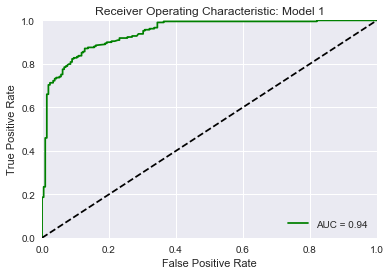

In [11]:
# calculate fpr & tpr / graph roc curve
probs = model_1.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic: Model 1')
plt.plot(fpr, tpr, 'green', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [12]:
print(model_1.best_params_)
print('Train Accuracy:', model_1.score(X_train, y_train))
print('Test Accuracy:', model_1.score(X_test, y_test))
print('Best CV Test Score:', model_1.best_score_)
print('AUC:', round(roc_auc, 4))

{'cvec__max_features': 200, 'cvec__min_df': 11, 'cvec__stop_words': 'english', 'logr__C': 0.1, 'logr__penalty': 'l2'}
Train Accuracy: 0.9010204081632653
Test Accuracy: 0.8574821852731591
Best CV Test Score: 0.8581632653061224
AUC: 0.9441


In [13]:
model_coef = model_1.best_estimator_.named_steps['logr'].coef_

In [14]:
model_feats = model_1.best_estimator_.named_steps['cvec'].get_feature_names()

In [15]:
model_coef[0].shape, len(model_feats)

((200,), 200)

In [16]:
coef_df = pd.DataFrame([model_feats, list(model_coef[0])], index=['features', 'coef']).T

In [17]:
np.exp([1,2,3])

array([ 2.71828183,  7.3890561 , 20.08553692])

In [18]:
np.exp(np.array([1,2,3]))

array([ 2.71828183,  7.3890561 , 20.08553692])

In [19]:
coef_df['e_coef'] = np.e**(coef_df['coef'])

In [64]:
coef_df.sort_values(by='e_coef',ascending=False).head()

#for every occurence of word 'uber', 6 times as likely to observe a positive class

,features,coef,e_coef
180,uber,1.79838,6.03983
134,rating,0.336501,1.40004
122,people,0.289465,1.33571
28,charged,0.285255,1.3301
50,driver,0.276226,1.31815


##### Interpreted coefficients:
For every increase in the appearance of the word 'uber', it is 6.04 times more likely for that post to be in the positive class (from the Uber subreddit). This was the highest coefficient - the next ones drop quite a bit ('rating': 1.40, 'people': 1.34, 'charged': 1.33), etc.


##### Calculated Confusion Matrix values:

In [71]:
confusion_matrix(y_test, y_preds)

array([[196,  16],
       [ 44, 165]])

In [72]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

In [73]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 196
False Positives: 16
False Negatives: 44
True Positives: 165


In [76]:
print("Accuracy:", ((tp + tn)/(tp + tn + fp + fn)))
print("Sensitivity:", (tp/(fp + tn)))
print("Specificity:", (tn/(fp + tn)))
print("Precision:", (tp/(tp + fp)))

Accuracy: 0.8574821852731591
Sensitivity: 0.7783018867924528
Specificity: 0.9245283018867925
Precision: 0.9116022099447514


## Model 2: Count Vectorizer + KNN

In [21]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())])

params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__min_df' : [2, 11, 22, 54],
    'cvec__max_features' : [None, 700, 500, 200, 20],
    'knn__n_neighbors': [2, 7, 11, 27, 77]}


model_2 = GridSearchCVProgressBar(pipe, params, cv = 3)
model_2.fit(X_train, y_train)

[........................................] 100% | 100.21 sec | GridSearchCV 


GridSearchCVProgressBar(cv=3, error_score='raise',
            estimator=Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
            fit_params=None, iid=True, n_jobs=1,
            param_grid={'cvec__stop_words': [None, 'english'], 'cvec__min_df': [2, 11, 22, 54], 'cvec__max_features': [None, 700, 500, 200, 20], 'knn__n_neighbors': [2, 7, 11, 27, 77]},
            pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
            scoring=None, verbose=0)

In [22]:
model_2.best_params_

{'cvec__max_features': None,
 'cvec__min_df': 11,
 'cvec__stop_words': 'english',
 'knn__n_neighbors': 77}

In [23]:
y_preds = model_2.predict(X_test)

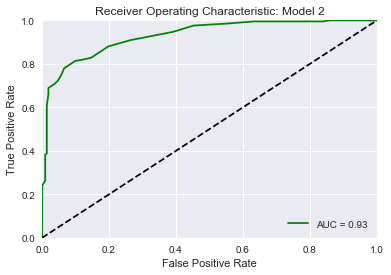

In [24]:
# calculate fpr & tpr / graph roc curve
probs = model_2.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic: Model 2')
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [25]:
print(model_2.best_params_)
print('Train Accuracy:', model_2.score(X_train, y_train))
print('Test Accuracy:', model_2.score(X_test, y_test))
print('Best CV Test Score:', model_2.best_score_)
print('AUC:', round(roc_auc, 4))

{'cvec__max_features': None, 'cvec__min_df': 11, 'cvec__stop_words': 'english', 'knn__n_neighbors': 77}
Train Accuracy: 0.8520408163265306
Test Accuracy: 0.8456057007125891
Best CV Test Score: 0.8489795918367347
AUC: 0.9302


## Model 3: Count Vectorizer + Naive Bayes

In [26]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())])

params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'cvec__min_df' : [2, 11, 22],
    'cvec__max_features' : [None, 700, 500, 200, 20],
    'nb__alpha': [1, 1e-1, 1e-2]}


model_3 = GridSearchCVProgressBar(pipe, params, cv = 3)
model_3.fit(X_train, y_train)

[........................................] 100% | 185.08 sec | GridSearchCV 


GridSearchCVProgressBar(cv=3, error_score='raise',
            estimator=Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
            fit_params=None, iid=True, n_jobs=1,
            param_grid={'cvec__stop_words': [None, 'english'], 'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)], 'cvec__min_df': [2, 11, 22], 'cvec__max_features': [None, 700, 500, 200, 20], 'nb__alpha': [1, 0.1, 0.01]},
            pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
            scoring=None, verbose=0)

In [27]:
model_3.best_params_

{'cvec__max_features': 700,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'nb__alpha': 1}

In [28]:
y_preds = model_3.predict(X_test)

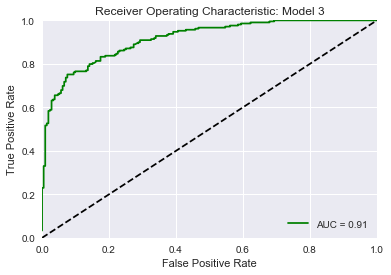

In [29]:
# calculate fpr & tpr / graph roc curve
probs = model_3.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic: Model 3')
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [30]:
print(model_3.best_params_)
print('Train Accuracy:', model_3.score(X_train, y_train))
print('Test Accuracy:', model_3.score(X_test, y_test))
print('Best CV Test Score:', model_3.best_score_)
print('AUC:', round(roc_auc, 4))

{'cvec__max_features': 700, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'nb__alpha': 1}
Train Accuracy: 0.8775510204081632
Test Accuracy: 0.8194774346793349
Best CV Test Score: 0.8204081632653061
AUC: 0.9146


## Model 4: Count Vectorizer + Random Forest

In [31]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())])

params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__min_df' : [2, 11, 22],
    'cvec__max_features' : [None, 700, 500, 200, 20],
    'rf__n_estimators': [10, 20, 50, 100, 200],
    'rf__max_depth': [2,7,11]}


model_4 = GridSearchCVProgressBar(pipe, params, cv = 3)
model_4.fit(X_train, y_train)

[........................................] 100% | 358.44 sec | GridSearchCV 


GridSearchCVProgressBar(cv=3, error_score='raise',
            estimator=Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
            fit_params=None, iid=True, n_jobs=1,
            param_grid={'cvec__stop_words': [None, 'english'], 'cvec__min_df': [2, 11, 22], 'cvec__max_features': [None, 700, 500, 200, 20], 'rf__n_estimators': [10, 20, 50, 100, 200], 'rf__max_depth': [2, 7, 11]},
            pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
            scoring=None, verbose=0)

In [32]:
model_4.best_params_


{'cvec__max_features': 700,
 'cvec__min_df': 2,
 'cvec__stop_words': 'english',
 'rf__max_depth': 11,
 'rf__n_estimators': 100}

In [33]:
y_preds = model_4.predict(X_test)

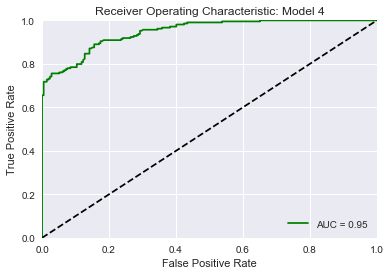

In [34]:
# calculate fpr & tpr / graph roc curve
probs = model_4.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic: Model 4')
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [35]:
print(model_4.best_params_)
print('Train Accuracy:', model_4.score(X_train, y_train))
print('Test Accuracy:', model_4.score(X_test, y_test))
print('Best CV Test Score:', model_4.best_score_)
print('AUC:', round(roc_auc, 4))


{'cvec__max_features': 700, 'cvec__min_df': 2, 'cvec__stop_words': 'english', 'rf__max_depth': 11, 'rf__n_estimators': 100}
Train Accuracy: 0.9387755102040817
Test Accuracy: 0.8527315914489311
Best CV Test Score: 0.8540816326530613
AUC: 0.9477


## Model 5: TF-IDF + Logistic Regression

In [36]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegression())])

params = {
    'tvec__stop_words': [None, 'english'],
    'tvec__min_df' : [10, 20, 50],
    'tvec__max_features' : [None, 700, 500, 200, 20],
    'logr__penalty': ['l1', 'l2'],
    'logr__C': [0.1, 0.4, 0.7, 1.0]}


model_5 = GridSearchCVProgressBar(pipe, params, cv = 3)
model_5.fit(X_train, y_train)

[........................................] 100% | 86.52 sec | GridSearchCV 


GridSearchCVProgressBar(cv=3, error_score='raise',
            estimator=Pipeline(memory=None,
     steps=[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
            fit_params=None, iid=True, n_jobs=1,
            param_grid={'tvec__stop_words': [None, 'english'], 'tvec__min_df': [10, 20, 50], 'tvec__max_features': [None, 700, 500, 200, 20], 'logr__penalty': ['l1', 'l2'], 'logr__C': [0.1, 0.4, 0.7, 1.0]},
            pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
            scoring=None, verbose=0)

In [37]:
model_5.best_params_

{'logr__C': 0.1,
 'logr__penalty': 'l1',
 'tvec__max_features': 200,
 'tvec__min_df': 10,
 'tvec__stop_words': 'english'}

In [38]:
y_preds = model_5.predict(X_test)

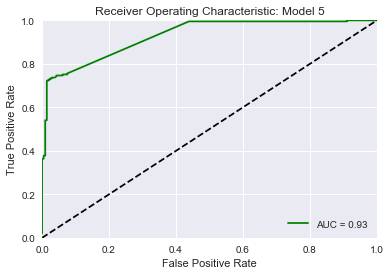

In [39]:
# calculate fpr & tpr / graph roc curve
probs = model_5.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic: Model 5')
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [40]:
print(model_5.best_params_)
print('Train Accuracy:', model_5.score(X_train, y_train))
print('Test Accuracy:', model_5.score(X_test, y_test))
print('Best CV Test Score:', model_5.best_score_)
print('AUC:', round(roc_auc, 4))

{'logr__C': 0.1, 'logr__penalty': 'l1', 'tvec__max_features': 200, 'tvec__min_df': 10, 'tvec__stop_words': 'english'}
Train Accuracy: 0.8520408163265306
Test Accuracy: 0.8551068883610451
Best CV Test Score: 0.8561224489795919
AUC: 0.9286


## Model 6: TF-IDF + KNN

In [41]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())])

params = {
    'tvec__stop_words': [None, 'english'],
    'tvec__min_df' : [10, 20, 50],
    'tvec__max_features' : [None, 700, 500, 200, 20],
    'knn__n_neighbors': [2, 7, 11, 27, 77]}


model_6 = GridSearchCVProgressBar(pipe, params, cv = 3)
model_6.fit(X_train, y_train)

[........................................] 100% | 73.63 sec | GridSearchCV 


GridSearchCVProgressBar(cv=3, error_score='raise',
            estimator=Pipeline(memory=None,
     steps=[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
            fit_params=None, iid=True, n_jobs=1,
            param_grid={'tvec__stop_words': [None, 'english'], 'tvec__min_df': [10, 20, 50], 'tvec__max_features': [None, 700, 500, 200, 20], 'knn__n_neighbors': [2, 7, 11, 27, 77]},
            pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
            scoring=None, verbose=0)

In [42]:
model_6.best_params_

{'knn__n_neighbors': 77,
 'tvec__max_features': 200,
 'tvec__min_df': 20,
 'tvec__stop_words': 'english'}

In [43]:
y_preds = model_6.predict(X_test)

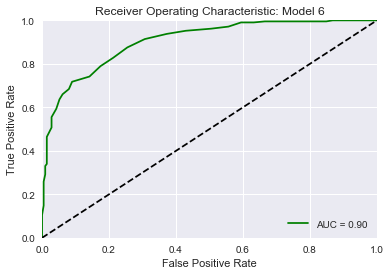

In [44]:
# calculate fpr & tpr / graph roc curve
probs = model_6.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic: Model 6')
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [45]:
print(model_6.best_params_)
print('Train Accuracy:', model_6.score(X_train, y_train))
print('Test Accuracy:', model_6.score(X_test, y_test))
print('Best CV Test Score:', model_6.best_score_)
print('AUC:', round(roc_auc, 4))

{'knn__n_neighbors': 77, 'tvec__max_features': 200, 'tvec__min_df': 20, 'tvec__stop_words': 'english'}
Train Accuracy: 0.8183673469387756
Test Accuracy: 0.8076009501187649
Best CV Test Score: 0.8295918367346938
AUC: 0.9041


## Model 7: TF-IDF + Naive Bayes

In [46]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())])

params = {
    'tvec__stop_words': [None, 'english'],
    'tvec__min_df' : [10, 20, 50],
    'nb__alpha': [1, 1e-1, 1e-2]}


model_7 = GridSearchCVProgressBar(pipe, params, cv = 3)
model_7.fit(X_train, y_train)

[........................................] 100% | 7.36 sec | GridSearchCV 


GridSearchCVProgressBar(cv=3, error_score='raise',
            estimator=Pipeline(memory=None,
     steps=[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...True,
        vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
            fit_params=None, iid=True, n_jobs=1,
            param_grid={'tvec__stop_words': [None, 'english'], 'tvec__min_df': [10, 20, 50], 'nb__alpha': [1, 0.1, 0.01]},
            pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
            scoring=None, verbose=0)

In [47]:
model_7.best_params_

{'nb__alpha': 1, 'tvec__min_df': 50, 'tvec__stop_words': 'english'}

In [48]:
y_preds = model_7.predict(X_test)

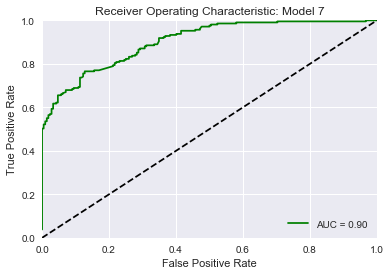

In [49]:
# calculate fpr & tpr / graph roc curve
probs = model_7.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic: Model 7')
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [50]:
print(model_7.best_params_)
print('Train Accuracy:', model_7.score(X_train, y_train))
print('Test Accuracy:', model_7.score(X_test, y_test))
print('Best CV Test Score:', model_7.best_score_)
print('AUC:', round(roc_auc, 4))

{'nb__alpha': 1, 'tvec__min_df': 50, 'tvec__stop_words': 'english'}
Train Accuracy: 0.8479591836734693
Test Accuracy: 0.7885985748218527
Best CV Test Score: 0.8214285714285714
AUC: 0.9029


## Model 8: TF-IDF + Random Forest

In [51]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())])

params = {
    'tvec__stop_words': [None, 'english'],
    'tvec__min_df' : [10, 20, 50],
    'rf__n_estimators': [10, 20, 50, 100, 200],
    'rf__max_depth': [2,7,11]
}


model_8 = GridSearchCVProgressBar(pipe, params, cv = 3)
model_8.fit(X_train, y_train)

[........................................] 100% | 78.45 sec | GridSearchCV 


GridSearchCVProgressBar(cv=3, error_score='raise',
            estimator=Pipeline(memory=None,
     steps=[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
            fit_params=None, iid=True, n_jobs=1,
            param_grid={'tvec__stop_words': [None, 'english'], 'tvec__min_df': [10, 20, 50], 'rf__n_estimators': [10, 20, 50, 100, 200], 'rf__max_depth': [2, 7, 11]},
            pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
            scoring=None, verbose=0)

In [52]:
model_8.best_params_

{'rf__max_depth': 11,
 'rf__n_estimators': 200,
 'tvec__min_df': 10,
 'tvec__stop_words': 'english'}

In [53]:
y_preds = model_8.predict(X_test)

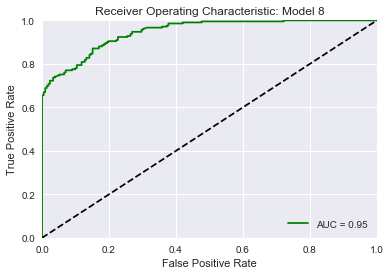

In [54]:
# calculate fpr & tpr / graph roc curve
probs = model_8.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic: Model 8')
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [55]:
print(model_8.best_params_)
print('Train Accuracy:', model_8.score(X_train, y_train))
print('Test Accuracy:', model_8.score(X_test, y_test))
print('Best CV Test Score:', model_8.best_score_)
print('AUC:', round(roc_auc, 4))

{'rf__max_depth': 11, 'rf__n_estimators': 200, 'tvec__min_df': 10, 'tvec__stop_words': 'english'}
Train Accuracy: 0.9408163265306122
Test Accuracy: 0.838479809976247
Best CV Test Score: 0.8540816326530613
AUC: 0.9464


## Model 9: Count Vectorizer + Logistic Regression
##### Same as Model 1, adding 'Lyft' and 'Uber' to stop words to investigate how this affects model performance.

In [56]:
stops = list(stop_words.ENGLISH_STOP_WORDS)

In [57]:
other = ['lyft', 'uber', 'Lyft', 'Uber']
stops.extend(other)

In [58]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stops)),
    ('logr', LogisticRegression())])

params = {
    'cvec__min_df' : [2, 11, 22, 54],
    'cvec__max_features' : [None, 700, 500, 200, 20],
    'logr__penalty': ['l1', 'l2'],
    'logr__C': [0.1, 0.4, 0.7, 1.0]}


model_9 = GridSearchCVProgressBar(pipe, params, cv = 3)
model_9.fit(X_train, y_train)

[........................................] 100% | 62.12 sec | GridSearchCV 


GridSearchCVProgressBar(cv=3, error_score='raise',
            estimator=Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['towards',...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
            fit_params=None, iid=True, n_jobs=1,
            param_grid={'cvec__min_df': [2, 11, 22, 54], 'cvec__max_features': [None, 700, 500, 200, 20], 'logr__penalty': ['l1', 'l2'], 'logr__C': [0.1, 0.4, 0.7, 1.0]},
            pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
            scoring=None, verbose=0)

In [59]:
model_9.best_params_

{'cvec__max_features': 500,
 'cvec__min_df': 2,
 'logr__C': 0.1,
 'logr__penalty': 'l2'}

In [60]:
y_preds = model_9.predict(X_test)

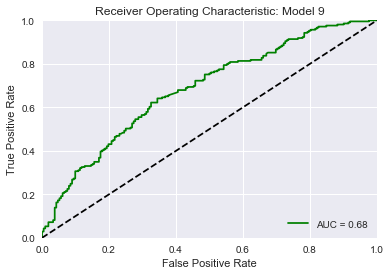

In [61]:
# calculate fpr & tpr / graph roc curve
probs = model_9.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic: Model 9')
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [62]:
print(model_9.best_params_)
print('Train Accuracy:', model_9.score(X_train, y_train))
print('Test Accuracy:', model_9.score(X_test, y_test))
print('Best CV Test Score:', model_9.best_score_)
print('AUC:', round(roc_auc, 4))

{'cvec__max_features': 500, 'cvec__min_df': 2, 'logr__C': 0.1, 'logr__penalty': 'l2'}
Train Accuracy: 0.8
Test Accuracy: 0.6389548693586699
Best CV Test Score: 0.6081632653061224
AUC: 0.6832


##### Removing 'lyft' and 'uber' from the stop words brings best accuracy score down from 85.7% to 63.89% (not much of an improvement from the baseline) and AUC ROC score from 0.94 to 0.68.

##### Overview of performance of all 9 models:

| Model | Rank | Transformation Method | Classification Model | Test Score  | Train Score | Best CV Score    | AUC ROC   | Processing Seconds |   |
|-------|------|-----------------------|----------------------|-------|-------|-------|-------|---------|---|
| 1     | 1    | Count Vectorizer      | Logistic Regression  | 0.857 | 0.901 | 0.858 | 0.944 | 137.22  |   |
| 5     | 2    | TF-IDF                | Logistic Regression  | 0.855 | 0.852 | 0.856 | 0.929 | 86.52   |   |
| 4     | 3    | Count Vectorizer      | Random Forest        | 0.853 | 0.938 | 0.854 | 0.948 | 358.44  |   |
| 2     | 4    | Count Vectorizer      | KNN                  | 0.846 | 0.852 | 0.849 | 0.930 | 100.21  |   |
| 8     | 5    | TF-IDF                | Random Forest        | 0.839 | 0.941 | 0.854 | 0.946 | 78.45   |   |
| 3     | 6    | Count Vectorizer      | Naive Bayes          | 0.819 | 0.878 | 0.820 | 0.915 | 185.08  |   |
| 6     | 7    | TF-IDF                | KNN                  | 0.808 | 0.818 | 0.830 | 0.904 | 73.63   |   |
| 7     | 8    | TF-IDF                | Naive Bayes          | 0.789 | 0.848 | 0.821 | 0.903 | 7.36    |   |
| 9     | 9    | Count Vectorizer      | Logistic Regression  | 0.639 | 0.800 | 0.608 | 0.683 | 62.12   |   |